# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra
using Plots
default(lw=3.0)

### Generating some random binary data

In [2]:
kernel = with_lengthscale(SqExponentialKernel(), 1.0)
N_train = 50
x = range(-10, 10; length=50)
x_test = range(-10, 10; length=500)
K = kernelmatrix(kernel, vcat(x, x_test))
f_all = rand(MvNormal(K + 1e-8I)) # Sample a random GP
f = f_all[1:N_train]
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5));

### We create a function to visualize the data

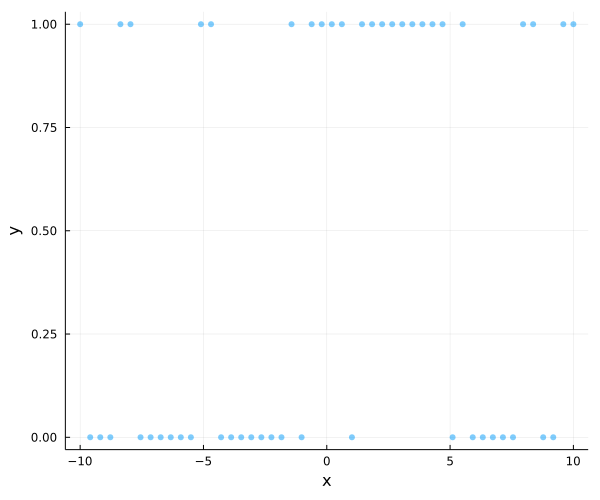

In [3]:
function plot_data(x, y; size=(300, 500), kwargs...)
    return Plots.scatter(x, y; alpha=0.5, markerstrokewidth=0.0, lab="", size=size, kwargs...)
end
plot_data(x, y; size=(600, 500), xlabel="x", ylabel="y")

## Model initialization and training
### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.906775 seconds (1.84 M allocations: 97.712 MiB, 99.51% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [0.8217978747065188, 0.8054381645217524, 0.7955435018304924, 0.7708220041379277, 0.7564268702274246, 0.7827747134193107, 0.8913413639766674, 1.0767146611503062, 1.2232111889194381, 1.2192376033537242  …  1.1199245622149532, 1.1598057917131712, 1.0523367089983364, 0.8825028961951024, 0.762618260518566, 0.7224551179895017, 0.7217215275645426, 0.7435067010799494, 0.7997260540150599, 0.8831282281763202], θ = [0.23681960207907093, 0.23730754544995836, 0.2375990581841473, 0.23831530745355017, 0.23872428856552375, 0.23797117700347964, 0.23466531889510758, 0.2283536845977139, 0.2228790643334996, 0.22303228936028643  …  0.2267784204536168, 0.2252941192921605, 0.22922640336321673, 0.23494610040754524, 0.23854912187192218, 0.23966529850338275, 0.23968523850401874, 0.23908620934248098, 0.23747616752

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000);

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:56
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:03:00
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:02:00
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:30
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:11
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:59
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:51
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:44
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:39
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:35
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:32
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:29
Sampling with Gibbs Sampler   6%|█▍     

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

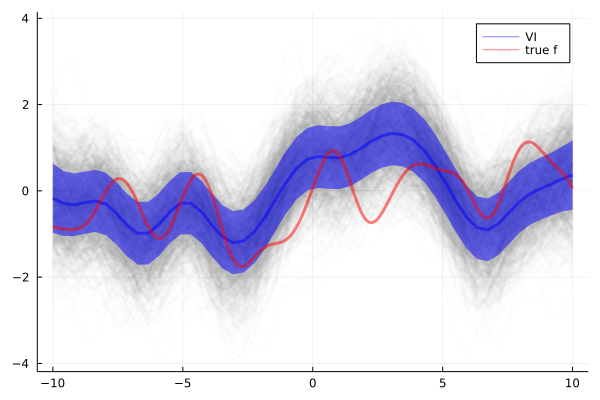

In [6]:
p1 = plot(x, samples; label="", color=:black, alpha=0.01, lab="")
plot!(x, mean(mfull[1]); color=:blue, ribbon=sqrt.(var(mfull[1])), label="VI")
plot!(x_test, f_all[N_train+1:end]; color=:red, label="true f")

### And we can also plot the predictions vs the data

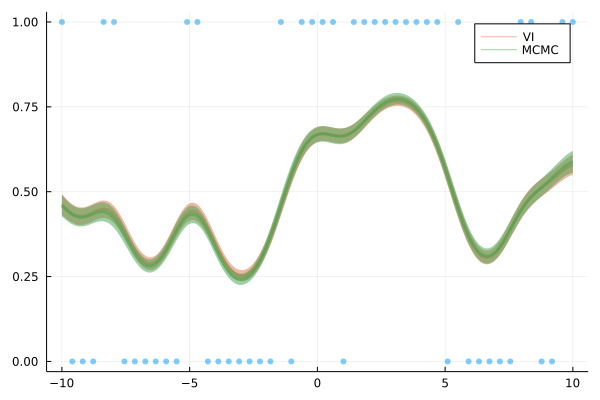

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x_test)
plot!(x_test, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x_test)
plot!(x_test, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*